In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import abc_load as abc
import nibabel
import anndata as ad
import numpy as np
import pandas as pd
import scipy.ndimage

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
cells_df = abc.get_combined_metadata()

In [5]:
ccf_df = pd.read_csv(
        abc.ABC_ROOT/"metadata/Allen-CCF-2020/20230630/parcellation_to_parcellation_term_membership.csv"
        )

In [6]:
th_zi_ind = np.hstack(
        (ccf_df.loc[ccf_df['parcellation_term_acronym']=='TH', 
                    'parcellation_index'].unique(),
             ccf_df.loc[ccf_df['parcellation_term_acronym']=='ZI', 
                    'parcellation_index'].unique())
)
len(th_zi_ind)

53

## resampled ccf (z resolution limited to merscope slices)

In [10]:
ccf_img = abc.get_ccf_labels_image(resampled=True)
ccf_img.shape

(1100, 1100, 76)

In [103]:
# takes about 5 sec
th_mask = np.isin(ccf_img, th_zi_ind)

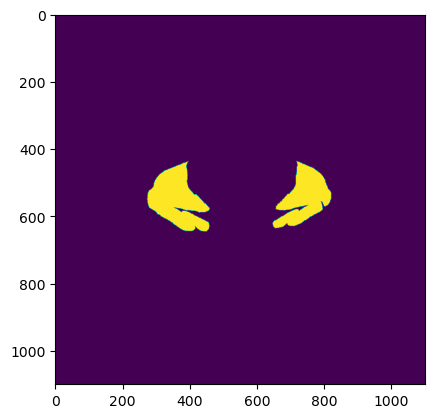

In [104]:
plt.imshow(th_mask[:,:,29].T)

In [158]:
def sectionwise_dilation(th_mask, dist, true_radius=True):
    out = np.zeros_like(th_mask)
    coords = np.mgrid[-dist:dist+1, -dist:dist+1]
    struct = np.linalg.norm(coords, axis=0) <= dist
    for i in range(th_mask.shape[2]):
        if true_radius:
            out[:,:,i] = scipy.ndimage.binary_dilation(th_mask[:,:,i], structure=struct)
        else:
            out[:,:,i] = scipy.ndimage.binary_dilation(th_mask[:,:,i], iterations=dist)
    return out

In [153]:
coords = ['x_reconstructed','y_reconstructed','z_reconstructed']
res = np.array([10e-3, 10e-3, 200e-3])
def label_thalamus_masked_cells(cells_df, th_mask, coords, res):
    coords_index = np.rint(cells_df[coords].values / res).astype(int)
    # tuple() makes this like calling th_mask[coords_index[:,0], coords_index[:,1], coords_index[:,2]]
    cells_df['thal_dataset'] = th_mask[tuple(coords_index.T)]

## comparison to subclasses

In [80]:
th_subclasses = ['168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', '101 ZI Pax6 Gaba',
                  '109 LGv-ZI Otx2 Gaba', '093 RT-ZI Gnb3 Gaba',
                  '149 PVT-PT Ntrk1 Glut', '151 TH Prkcd Grin2c Glut',
                  '152 RE-Xi Nox4 Glut', '154 PF Fzd5 Glut',
                  '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba',
                  '148 AV Col27a1 Glut', '146 LH Pou4f1 Sox1 Glut',
                  '147 AD Serpinb7 Glut', '153 MG-POL-SGN Nts Glut',
                  '110 BST-po Iigp1 Glut', '150 CM-IAD-CL-PCN Sema5b Glut',
                  '145 MH Tac2 Glut']
cells_df['thal_subclass'] = cells_df["subclass"].isin(th_subclasses)

In [161]:
data = dict()
for radius in [1,5,10,15,20,30]:
    mask = sectionwise_dilation(th_mask, radius, true_radius=False)
    label_thalamus_masked_cells(cells_df, mask, coords, res)
    data[radius] = (cells_df.loc[cells_df['thal_subclass']]
        .groupby('z_reconstructed')['thal_dataset'].mean().loc[lambda x: x>0])
    


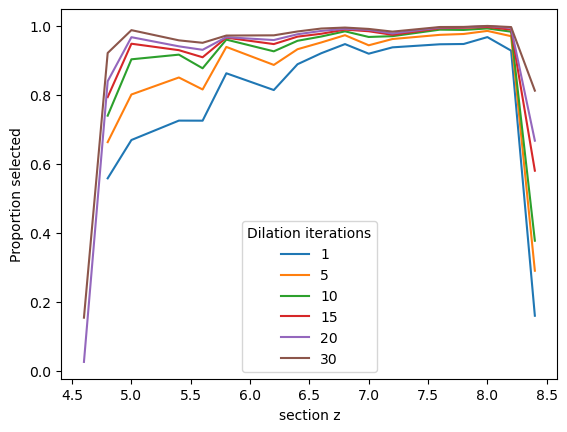

In [162]:
for i, xy in data.items():
    plt.plot(xy, label=i)

plt.ylabel('Proportion selected')
plt.xlabel('section z')
plt.legend(title='Dilation iterations')

Using a true dilation by radius takes much longer, doesn't look much different.

In [154]:
data = dict()
for radius in [1,5,10,15,20,30]:
    mask = sectionwise_dilation(th_mask, radius, true_radius=True)
    label_thalamus_masked_cells(cells_df, mask, coords, res)
    data[radius*0.01] = (cells_df.loc[cells_df['thal_subclass']]
        .groupby('z_reconstructed')['thal_dataset'].mean().loc[lambda x: x>0])
    


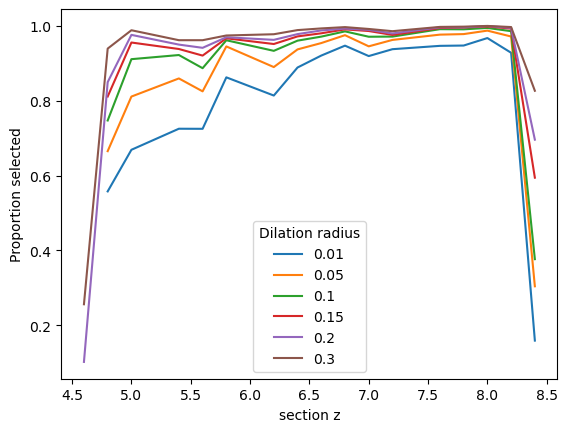

In [157]:
for i, xy in data.items():
    plt.plot(xy, label=i)

plt.ylabel('Proportion selected')
plt.xlabel('section z')
plt.legend(title='Dilation radius')

Note that the issues are primarily with the posterior sections.

Seems best to go with 10-15 iterations (100-150 um), but still isn't perfect.

Dropping sections 8.4 (not included previously) and 4.8 (included previously) seems safest for now (see plots below).

In [163]:
mask = sectionwise_dilation(th_mask, 10, true_radius=False)
label_thalamus_masked_cells(cells_df, mask, coords, res)

### test end-to-end function

In [19]:
th_df = abc.label_thalamus_spatial_subset(cells_df, distance_px=10, filter=True)

In [20]:
sorted(th_df['z_section'].unique())

[5.0,
 5.4,
 5.6000000000000005,
 5.800000000000001,
 6.2,
 6.4,
 6.6000000000000005,
 6.800000000000001,
 7.0,
 7.2,
 7.6,
 7.800000000000001,
 8.0,
 8.200000000000001]

### compare to Brian's outline dataset

In [169]:
old_ids = abc.get_thalamus_reference_ids().intersection(cells_df.index)
new_ids = cells_df.query("thal_dataset").index

In [170]:
len(old_ids.intersection(new_ids))

161215

In [172]:
len(new_ids.difference(old_ids))

34112

In [ ]:
len(old_ids.difference(new_ids))

3596

The new outline adds about 2% more new cells. Could also be worth checking on where the cells not in the old version are located...

In [175]:
cells_df.loc[old_ids.difference(new_ids), 'z_reconstructed'].value_counts().sort_index()

z_reconstructed
4.8    206
5.0     64
5.4      7
5.6    239
5.8     77
6.2    324
6.4    201
6.6    655
6.8    141
7.0    359
7.2     87
7.6    355
7.8    275
8.0    163
8.2    443
Name: count, dtype: int64

In [177]:
cells_df.loc[old_ids.difference(new_ids), 'subclass'].value_counts().head(10)

subclass
327 Oligo NN                              882
318 Astro-NT NN                           564
323 Ependymal NN                          286
325 CHOR NN                               229
333 Endo NN                               217
101 ZI Pax6 Gaba                          216
330 VLMC NN                               188
168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut    130
319 Astro-TE NN                            88
151 TH Prkcd Grin2c Glut                   83
Name: count, dtype: int64

### examine end sections with poor match

(4.0, 7.0)

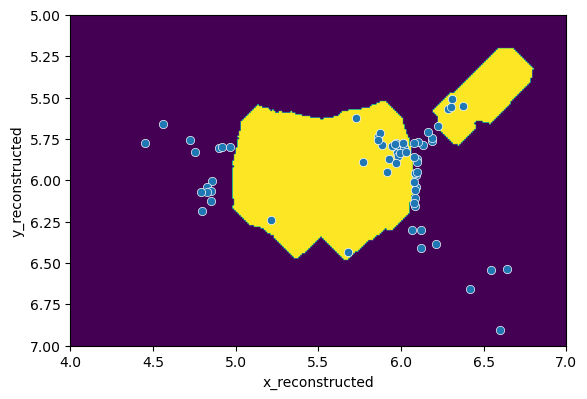

In [126]:
z = 8.4
plt.imshow(mask[:,:, int(z/0.2)].T, extent=[0, 11, 11, 0])
sns.scatterplot(data=cells_df.query(f"thal_subclass & z_reconstructed=={z}"), x=coords[0], y=coords[1])
plt.ylim(7, 5)
plt.xlim(4, 7)

(2.0, 8.0)

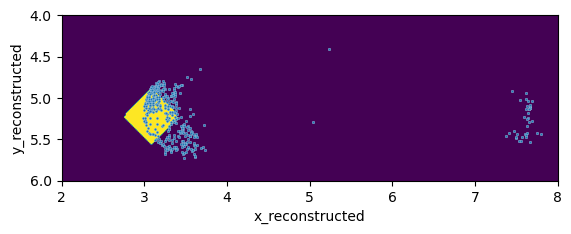

In [137]:
z = 4.8
plt.imshow(mask[:,:, int(z/0.2)].T, extent=[0, 11, 11, 0])
sns.scatterplot(data=cells_df.query(f"thal_subclass & z_reconstructed>{z-0.1} & z_reconstructed<{z+0.1}"), x=coords[0], y=coords[1], s=4)
plt.ylim(6, 4)
plt.xlim(2, 8)

<Axes: xlabel='x_reconstructed', ylabel='y_reconstructed'>

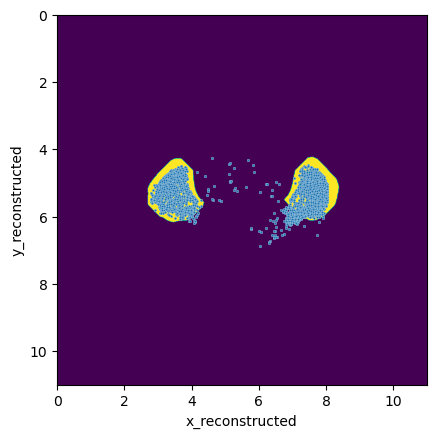

In [ ]:
z = 5.6
plt.imshow(mask[:,:, int(z/0.2)].T, extent=[0, 11, 11, 0])
sns.scatterplot(data=cells_df.query(f"thal_subclass & z_reconstructed>{z-0.1} & z_reconstructed<{z+0.1}"), x=coords[0], y=coords[1], s=4)
# plt.ylim(7, 5)
# plt.xlim(4, 7)

## full 10um ccf

In [ ]:
# very slow to do operations with this large image volume

# ccf_img = abc.get_ccf_labels_image()
# # takes about 1 min
# th_mask = np.isin(ccf_img, th_zi_ind)